In [35]:
from class_definitions import Program, Merit, Target, Observation, Plan, Night
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astroplan
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz
import merits
import astropy.units as u
from tqdm.notebook import tqdm
import scheduler
from datetime import date, timedelta, datetime
import pickle

In [36]:
# Define global observer location
lasilla = astroplan.Observer.at_site("lasilla")

In [37]:
# Define the programs
# Eventually this would be imported from the gitlab with the files.
prog600 = Program(600, 2, instrument="CORALIE")
prog703 = Program(703, 13, instrument="CORALIE")
prog708 = Program(708, 7, instrument="CORALIE")
prog714 = Program(714, 2, instrument="CORALIE")

In [38]:
start_datetime = Time("2023-10-20 03:00:00")


In [39]:
# Time(datetime.combine(date(2023, 10, 20), datetime.min.time()))
start_datetime.datetime.date()

night = Night(start_datetime.datetime.date() - timedelta(days=1))

## Define a target and add merits

In [40]:
# Define merits
cadence_merit = Merit("Cadence", merits.cadence, 
                      merit_type="efficiency", 
                      parameters={"delay": TimeDelta(4*u.day), "alpha":0.05})
airmass_merit = Merit("Airmass", merits.airmass, merit_type="veto", parameters={'max':1.5})
altitude_merit = Merit("Altitude", merits.altitude, merit_type="veto")
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto", parameters={'which':'nautical'})
culmination_merit = Merit("Culmination", merits.culmination, merit_type="efficiency")
egress_merit = Merit("Egress", merits.egress, merit_type="efficiency")

Targets from 708

In [41]:
# Test targets for the night of 2023-10-20
test_targets = ['HD224953A', 'CD-3931', 'CD-33501', 'BD-21397', 'HD16157',
                'CD-231056', 'CD-341770', 'HD32965', 'HD35650', 'HD274919',
                'BD-221344', 'CD-492340A', 'CD-422626', 'HD51199B', 'BD-141750',
                'BD-191855', 'HD58760', 'CD-363646', 'HD66020',
                'CD-81812', 'HD214100', 'HD218294']

# Create the targets
targets_708 = []
for tar_name in tqdm(test_targets):
    last_obs = start_datetime-5*u.day
    target = Target(tar_name, prog708, coords=SkyCoord.from_name(tar_name), last_obs=last_obs)
    target.add_merit(cadence_merit)
    # target.add_merit(airmass_merit)
    target.add_merit(culmination_merit)
    target.add_merit(egress_merit)
    target.add_merit(altitude_merit)
    target.add_merit(at_night_merit)
    targets_708.append(target)

  0%|          | 0/22 [00:00<?, ?it/s]

In [42]:
len(test_targets)

22

In [43]:
print(targets_708[4])

Target(Name: {self.name},
       Program: 708,
       Coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (38.59402579, -43.79635253)>,
       Last observation: 2460232.625,
       Merits: [Merit(Cadence, efficiency), Merit(Culmination, efficiency), Merit(Egress, efficiency), Merit(Altitude, veto), Merit(AtNight, veto)],
       Time share allocated: 7,
       Time share current: 0.0,
       Time share pct diff: 0.0)


Targets from 714

In [44]:
# Load targets from 714 vthat are observable on the 20th of October 2023
cor714 = pd.read_csv("Prog714COR_priorP3_2023-10-20.csv", skiprows=1, sep="\t")
cor714.head()

,catalog name,SIMBAD id,DACE name,coordinates (DACE),cadence [d],days overdue,cadence percentage overdue [%],comments for the observer
0,HD27256,* alf Ret,HIP19780,4:14:25.5 / -62:28:26,360.0,6.0,1.7,NaN
1,HD38042,HD 38042,HIP26589,5:39:07.0 / -58:57:27,20.0,4.0,20.0,NaN
2,HD63295,* zet Vol,HIP37504,7:41:49.3 / -72:36:22,180.0,79.2,44.0,NaN
3,HD63744,* Q Pup,HIP38089,7:48:20.2 / -47:04:40,180.0,79.2,44.0,NaN
4,HD65638,HD 65638,HIP38925,7:57:54.8 / -40:47:04,180.0,79.2,44.0,NaN


In [45]:
targets_714 = []
for i, tar in cor714.iterrows():
    last_obs = start_datetime-5*u.day
    tar_coords = tar['coordinates (DACE)'].split(" / ")
    skycoord = SkyCoord(tar_coords[0], tar_coords[1], unit=(u.hourangle, u.deg))
    target = Target(tar['catalog name'], prog714, coords=skycoord, last_obs=last_obs)
    target.add_merit(cadence_merit)
    # target.add_merit(airmass_merit)
    target.add_merit(culmination_merit)
    target.add_merit(egress_merit)
    target.add_merit(altitude_merit)
    target.add_merit(at_night_merit)
    targets_714.append(target)

### Build the observations

In [46]:
# Merge the two programs
targets_all = targets_708 + targets_714

In [47]:
exp_time = TimeDelta(15*u.min)
# Check if pickle file exists otherwise create from scratch
try:
    with open("test_observations.pkl", "rb") as f:
        test_observations = pickle.load(f)
except:
    test_observations = [Observation(target, 
                                    start_time=start_datetime, 
                                    exposure_time=exp_time,
                                    night=night) for target in tqdm(targets_all)]
    # Save the observation
    pickle.dump(test_observations, open("test_observations.pkl", "wb"))


## Test the merits

In [48]:
test_obs = test_observations[0]
print(f"Cadence merit = {cadence_merit.evaluate(test_obs, verbose=True)}")

observation.start_time = 2460237.5121279154
observation.target.last_obs = 2460232.5416666665
delay.value = 4.0
pct_overdue = 0.24261531222146004
<class 'numpy.float64'>
Cadence merit = 0.8115222702931268


In [49]:
print(f"Airmass merit = {airmass_merit.evaluate(test_obs, verbose=True)}")

Max airmass: 1.4158326164174004
Airmass within limits, return merit.
Airmass merit = 0.7062981798868171


In [50]:
print(f"Altitude merit = {altitude_merit.evaluate(test_obs)}")

Altitude merit = 1.0


In [51]:
print(f"Culmination merit = {culmination_merit.evaluate(test_obs, verbose=True)}")

Current altitude: 44.93451768011857
Max altitude: 51.10576144784111
Min altitude: 25.596559288406713
Altitude proportion: 0.7580777427239075
Culmination merit = 0.7580777427239075


In [52]:
print(f"Egress merit = {egress_merit.evaluate(test_obs, verbose=True)}")

Current time: 2460237.5121279154
First time: 2460237.315166477
Last time: 2460237.9252071166
Observable range proportion: 0.32286609370155084
Egress merit = 0.32286609370155084


In [53]:
test_obs.evaluate_score(verbose=True)

Fairness: 1
Sensibility: 1.0
Efficiency: 0.6308220355728618
Rank score: 0.6308220355728618


0.6308220355728618

# Test the Schedulers

## Simple greedy search

In [54]:
# Create the plan
plan = scheduler.forwardP(night.astronomical_evening, test_observations, 20)

In [55]:
# print(plan)

In [56]:
plan.evaluate_plan()

0.5176091870898623

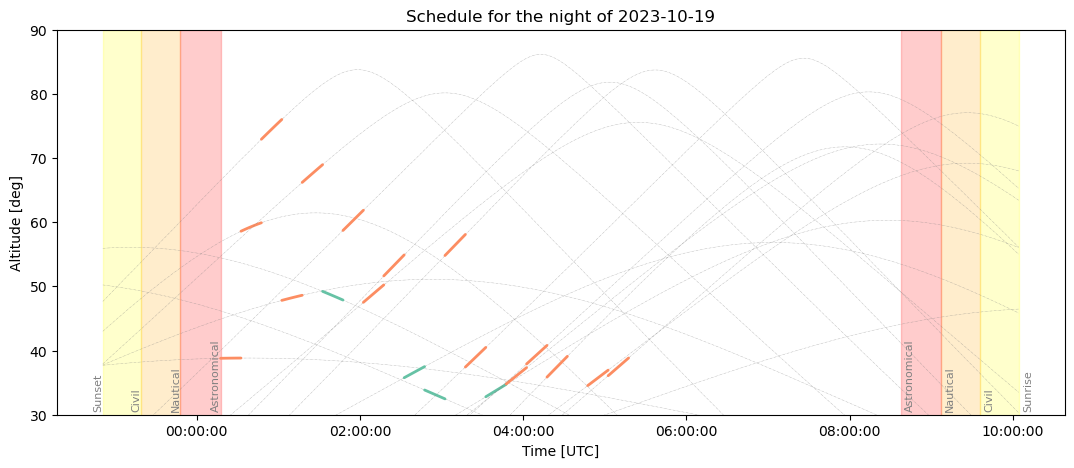

In [57]:
plan.plot()

## Recursive Dynamic Programming

In [58]:
# Create new list of targets without the egress merit
# By taking the current list of targets and removing the egress merit
try:
    test_observations_noegress = pickle.load(open("obs_noegress.pkl", "rb"))
except:
    targets_noegress = []
    for target in targets_all:
        target_noegress = Target(target.name, target.program, coords=target.coords, last_obs=Time(target.last_obs, format='jd'))
        target_noegress.add_merit(cadence_merit)
        target_noegress.add_merit(culmination_merit)
        target_noegress.add_merit(altitude_merit)
        target_noegress.add_merit(at_night_merit)
        targets_noegress.append(target_noegress)

    # Create the new observations with the new targets
    test_observations_noegress = [Observation(target, 
                                            start_time=start_datetime, 
                                            exposure_time=TimeDelta(15*u.min), 
                                            night=night) for target in tqdm(targets_noegress)]
    # Save to file
    pickle.dump(test_observations_noegress, open("obs_noegress.pkl", "wb"))

  0%|          | 0/59 [00:00<?, ?it/s]

In [59]:
# dpplanner = scheduler.DPPlanner()

# dpplan = dpplanner.dp_recursion(test_observations_noegress, 
#                                 Plan(), 
#                                 max_plan_length=10,
#                                 K = 4)

In [60]:
# print(f"Total recursion calls: {dpplanner.total_counter}")
# print(f"Saved recursion calls: {dpplanner.saved_state_counter}")

# print(dpplan[1])

In [61]:
# dpplan[1].plot()

In [62]:
# Time(night.astronomical_evening, format='jd')
test_observations_noegress[0]

Observation(Target: HD224953A,
            Start time: 2460237.625,
            Exposure time: 0.010416666666666666,
            Score: 0.0)

## Beam Search

In [67]:
beamsearch = scheduler.BeamSearchPlanner()

bs_plan = beamsearch.dp_beam_search(test_observations_noegress, 
                                    max_plan_length=15, 
                                    K=5)

Went through the 0 level
Went through the 1 level
Went through the 2 level
Went through the 3 level
Went through the 4 level
Went through the 5 level
Went through the 6 level
Went through the 7 level
Went through the 8 level
Went through the 9 level
Went through the 10 level
Went through the 11 level
Went through the 12 level
Went through the 13 level
Went through the 14 level


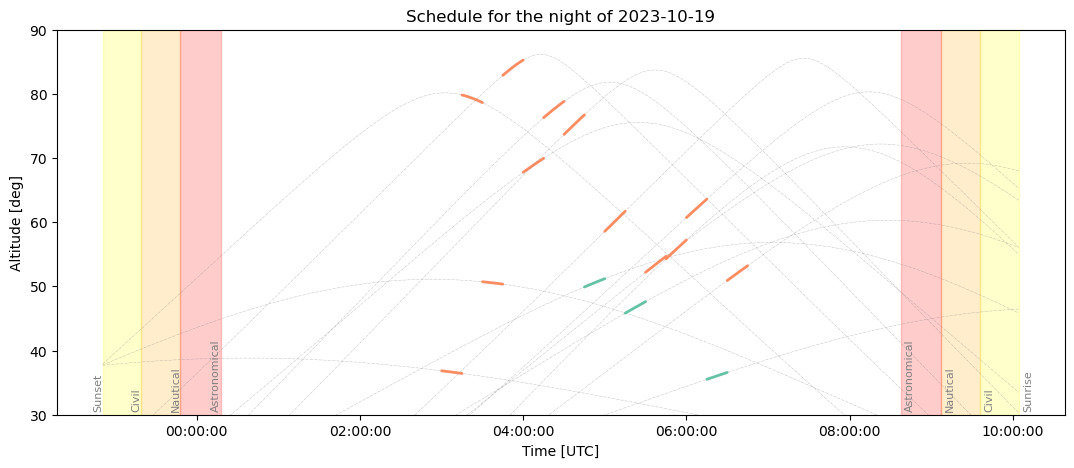

In [68]:
bs_plan.plot()

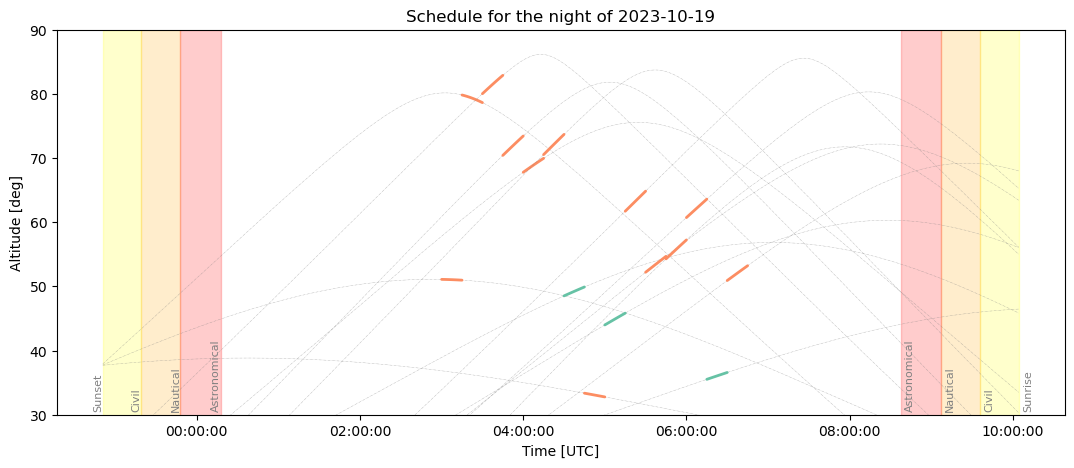

In [65]:
bs_plan.plot()

In [66]:
bs_plan.evaluate_plan()

0.7876769975570671